In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import time
import sys

import cv2

import os
import sys

# Add the parent directory to sys.path to find the utils package
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.colormaps import b_viridis, b_winter  
from utils.normalization import normalize_range, un_normalize_range
from utils.image_overlay import image_overlay
from utils.seed import set_seed

import tqdm

import numpy as np
import pypulseq
import scipy.io as sio

from cest_mrf.write_scenario import write_yaml_dict
from cest_mrf.dictionary.generation import generate_mrf_cest_dictionary
from cest_mrf.metrics.dot_product import  dot_prod_matching

from sequences import write_sequence
from configs import ConfigMouse

from dataset import SequentialDataset
from model import Network

import random

set_seed(2024)

Random seed set as 2024


In [2]:
data_f = 'data'
output_f = 'results'

os.makedirs(output_f, exist_ok=True)

In [3]:
# MRF acquisition protocol params

# saturation pulse frequency offsets (ppm)
ppm = [8.0, 6.0, 6.0, 10.0, 10.0, 10.0, 8.0, 6.0, 8.0, 14.0, 14.0, 10.0, 6.0,
        10.0, 8.0, 6.0, 8.0, 10.0, 14.0, 14.0, 6.0, 8.0, 14.0, 6.0, 14.0, 14.0, 14.0, 8.0, 10.0, 8.0] 

# Saturation pulse power
b1 = [2.0, 2.0, 1.7, 1.5, 1.2, 1.2, 3.0, 0.5, 3.0, 1.0, 2.2,
    3.2, 1.5, 0.7, 1.5, 2.2, 2.5, 1.2, 3.0, 0.2, 1.5, 2.5, 0.7, 4.0, 3.2, 3.5, 1.5, 2.7, 0.7, 0.5]

TR = [3.5] * len(b1)
Tsat = 2.5
cfg = ConfigMouse().get_config()

In [4]:
# Define output filenames
yaml_fn = cfg['yaml_fn']
seq_fn = cfg['seq_fn']
dict_fn = cfg['dict_fn']

# Write the .yaml according to the config.py file (inside cest_mrf folder)
write_yaml_dict(cfg, yaml_fn)

# Write the seq file for a 2d experiment
# for more info about the seq file, check out the pulseq-cest repository
seq_defs = {}
seq_defs['n_pulses'] = 1  # number of pulses
seq_defs['tp'] = Tsat  # pulse duration [s]
seq_defs['td'] = 0  # interpulse delay [s]
seq_defs['Trec'] = np.array(TR) - Tsat  # delay before readout [s]
seq_defs['Trec_M0'] = 'NaN'  # delay before m0 readout [s]
seq_defs['M0_offset'] = 'NaN'  # dummy m0 offset [ppm]
seq_defs['DCsat'] = seq_defs['tp'] / (seq_defs['tp'] + seq_defs['td'])  # duty cycle
seq_defs['offsets_ppm'] = ppm # offset vector [ppm]
seq_defs['num_meas'] = len(seq_defs['offsets_ppm'])  # number of repetition
seq_defs['Tsat'] = seq_defs['n_pulses'] * (seq_defs['tp'] + seq_defs['td']) - seq_defs['td']

seq_defs['B0'] = cfg['b0']  # B0 [T]

seqid = os.path.splitext(seq_fn)[1][1:]
seq_defs['seq_id_string'] = seqid  # unique seq id

# Varied saturation pulse power
seq_defs['B1pa'] = b1

# Create .seq file
write_sequence(seq_defs, seq_fn)

# The t1 of the solute  is set to vary together with that of water
equals = [('tw1', 'ts1_0')]

start = time.perf_counter()
dictionary = generate_mrf_cest_dictionary(seq_fn=seq_fn, param_fn=yaml_fn, dict_fn=dict_fn, num_workers=cfg['num_workers'],
                                axes='xy', equals=equals)  # axes can also be 'z' if no readout is simulated
end = time.perf_counter()
s = (end - start)
print(f"Dictionary simulation and preparation took {s:.03f} s.")


/home/hash/code/cest/nature_protocols_clean/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  arb_grad_mask = grad_lib_values == 'g'
/home/hash/code/cest/nature_protocols_clean/open-py-cest-mrf/cest_mrf/pypulseq/pypulseq/Sequence/write_seq.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  trap_grad_mask = grad_lib_values == 't'


No MT pools found in param files! specify with "mt_pool" if needed
Found 26400 different parameter combinations.
Dictionary generation started. Please wait...


CPU thread #12 is finished: 100%|██████████| 26400/26400 [00:00<00:00, 43934.61it/s]


Dictionary simulation took 0.600 s.
Dictionary simulation and preparation took 0.636 s.


In [5]:
if torch.cuda.is_available():
    device = 'cuda'
    print('GPU found and will be used')
else:
    device = 'cpu'
    print('No GPU found. CPU will be used')

GPU found and will be used


In [6]:
# Using water T1 and T2 maps and arranging input
temp_data = sio.loadmat(cfg['dict_fn'] )
min_fs = np.min(temp_data['fs_0'])
min_ksw = np.min(temp_data['ksw_0'].transpose().astype(np.float))
max_fs = np.max(temp_data['fs_0'])
max_ksw = np.max(temp_data['ksw_0'].transpose().astype(np.float))

min_t1w = np.min(temp_data['t1w'])
min_t2w = np.min(temp_data['t2w'].transpose().astype(np.float))
max_t1w = np.max(temp_data['t1w'])
max_t2w = np.max(temp_data['t2w'].transpose().astype(np.float))

min_param_tensor = torch.tensor(np.hstack((0, 0)), requires_grad=False)
max_param_tensor = torch.tensor(np.hstack((max_fs, max_ksw)), requires_grad=False)

# min_water_t1t2_tensor = torch.tensor(np.hstack((min_t1w, min_t2w)), requires_grad=False)
# max_water_t1t2_tensor = torch.tensor(np.hstack((max_t1w, max_t2w)), requires_grad=False)

min_water_t1t2_tensor = torch.tensor(np.hstack((0, 0)), requires_grad=False)
max_water_t1t2_tensor = torch.tensor(np.hstack((10, 1)), requires_grad=False)

del temp_data, min_fs, min_ksw, max_fs, max_ksw, min_t1w, min_t2w, max_t1w, max_t2w

In [7]:
# Schedule iterations
# number of raw images in the CEST-MRF acquisition schedule
sched_iter = 30

# Training properties
learning_rate = 2e-4
batch_size = 1024
num_epochs = 150
noise_std = 0.01 # noise level for training

min_delta = 0.05  # minimum absolute change in the loss function
patience = np.inf

# Initializing the reconstruction network
reco_net = Network(sched_iter, n_hidden=2, n_neurons=300).to(device)

# print amount of parameters
print('Amount of the model parameters: ', sum(p.numel() for p in reco_net.parameters() if p.requires_grad))

# Setting optimizer
optimizer = torch.optim.Adam(reco_net.parameters(), lr=learning_rate)

# Loading the training dataset
dataset = SequentialDataset(dict_fn)
train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)



Amount of the model parameters:  192302
There are 26400 entries in the training dictionary


In [8]:
# Storing current time
t0 = time.time()

loss_per_epoch = []
patience_counter = 0
min_loss = 100

reco_net.train()

#   Training loop   #
# ################# #
pbar = tqdm.tqdm(total=num_epochs)
for epoch in range(num_epochs):
    # Cumulative loss
    cum_loss = 0
    counter = np.nan

    for counter, dict_params in enumerate(train_loader, 0):
        cur_fs, cur_ksw, cur_t1w, cur_t2w, cur_norm_sig = dict_params

        target = torch.stack((cur_fs, cur_ksw), dim=1)
        input_water_t1t2 = torch.stack((cur_t1w, cur_t2w), dim=1)

        # Normalizing the target and input_water_t1t2
        target = normalize_range(original_array=target, original_min=min_param_tensor,
                                 original_max=max_param_tensor, new_min=0, new_max=1).to(device)

        input_water_t1t2 = normalize_range(original_array=input_water_t1t2, original_min=min_water_t1t2_tensor,
                                           original_max=max_water_t1t2_tensor, new_min=0, new_max=1)

        # Adding noise to the input signals (trajectories) a
        noised_sig = cur_norm_sig + torch.randn(cur_norm_sig.size()) * noise_std

        # adding the water_t1t2 input as two additional elements in the noised_sig vector
        noised_sig = torch.hstack((input_water_t1t2, noised_sig))

        # Forward step
        prediction = reco_net(noised_sig.to(device).float())

        # Batch loss (MSE)
        loss = torch.mean((prediction.float() - target.float()) ** 2)

        # Backward step
        optimizer.zero_grad()
        loss.backward()

        # Optimization step
        optimizer.step()

        # Storing Cumulative loss
        cum_loss += loss.item()


    # Average loss for this epoch
    loss_per_epoch.append(cum_loss / (counter + 1))

    pbar.set_description(f'Epoch: {epoch+1}/{num_epochs}, Loss = {loss_per_epoch[-1]}')
    pbar.update(1)
    if (min_loss - loss_per_epoch[-1])/min_loss > min_delta:    
        min_loss = loss_per_epoch[-1]
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter > patience:
        print('Early stopping!')
        break

    
print(f"Training took {time.time() - t0:.2f} seconds")

chk_name = 'checkpoint_m.pt'

torch.save({
    'model_state_dict': reco_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),  #
    'loss_per_epoch': loss_per_epoch,
}, chk_name)
print(f"The optimized model, optimizer state, and loss history were saved to the file: '{chk_name}'")


Epoch: 150/150, Loss = 0.0325306411832571: 100%|██████████| 150/150 [01:49<00:00,  1.45it/s]  

Training took 109.75 seconds
The optimized model, optimizer state, and loss history were saved to the file: 'checkpoint_m.pt'


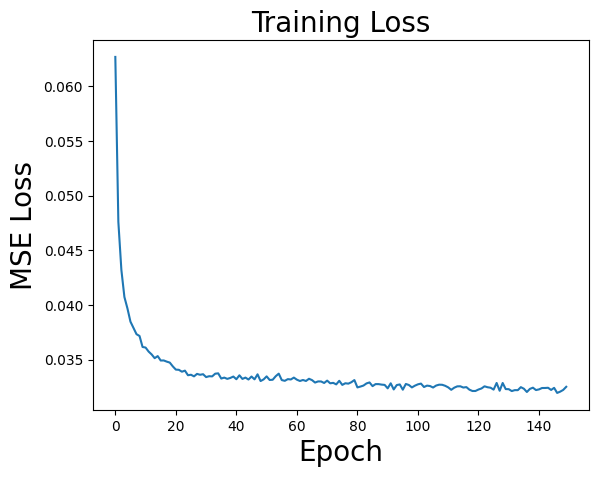

In [9]:
# Plotting training loss
plt.figure()
plt.plot(loss_per_epoch[0:])
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('MSE Loss', fontsize=20)
plt.title('Training Loss', fontsize=20)
plt.show()


In [10]:
checkpoint = torch.load('checkpoint_m.pt')
reco_net.load_state_dict(checkpoint['model_state_dict'])


<All keys matched successfully>

In [14]:
acquired_data_orig = sio.loadmat(os.path.join(data_f,'acquired_data_mouse.mat'))['data']
acquired_data_orig.shape

(30, 64, 64)

In [15]:
t12 = sio.loadmat(os.path.join(data_f, 't1_t2_maps_mouse.mat'))
t1 = t12['t1']
t2 = t12['t2']


In [16]:
# Loading the acquired data
[_, c_acq_data, w_acq_data] = np.shape(acquired_data_orig)

# Reshaping the acquired data to the shape expected by the NN (e.g. 30 x ... )
acquired_data = np.reshape(acquired_data_orig, (sched_iter, c_acq_data * w_acq_data), order='F')

# 2-norm normalization of the signals
acquired_data = acquired_data / np.linalg.norm(acquired_data, axis=0, ord=2)

# Transposing for compatibility with the NN - now each row is a trajectory
acquired_data = acquired_data.T

# Converting to tensor
acquired_data_sig = torch.from_numpy(acquired_data).to(device).float()


# >>> Loading the separately acquired water_t1t2-maps
acquired_map_t1w_orig = t1.astype(np.float32) / 1000
acquired_map_t2w_orig = t2.astype(np.float32) / 1000

# Reshaping the acquired data to the shape expected by the NN (e.g. 2 x ... )
# And transposing for compatibility with the NN - now each row is a trajectory
acquired_map_t1w = np.reshape(acquired_map_t1w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t1w = torch.from_numpy(acquired_map_t1w)

acquired_map_t2w = np.reshape(acquired_map_t2w_orig, (1, c_acq_data * w_acq_data), order='F').T
acquired_map_t2w = torch.from_numpy(acquired_map_t2w)

# Normalizing according to dict water_t1t2 min and max values
input_water_t1t2_acquired = torch.hstack((acquired_map_t1w, acquired_map_t2w))
input_water_t1t2_acquired = normalize_range(original_array=input_water_t1t2_acquired,
                                            original_min=min_water_t1t2_tensor,
                                            original_max=max_water_t1t2_tensor, new_min=0, new_max=1).to(device)

# adding the water_t1t2 input as two additional elements in the noised_sig vector
acquired_data = torch.hstack((input_water_t1t2_acquired, acquired_data_sig)).to(device).float()
# <<<
print("acquired data (raw MRF + T1 + T2) shape: " + str(acquired_data.shape))



acquired data (raw MRF + T1 + T2) shape: torch.Size([4096, 32])


In [17]:
print("Original raw MRF images shape:" + str(acquired_data_orig.shape))

Original raw MRF images shape:(30, 64, 64)


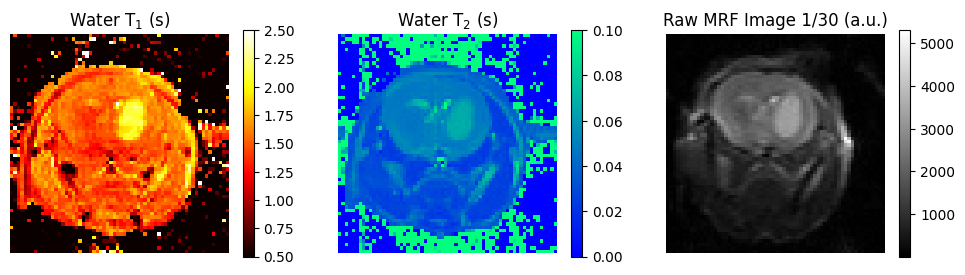

In [18]:
plt.figure(figsize=(12,10))
plt.subplot(331)
plt.imshow(acquired_map_t1w_orig, cmap='hot')
plt.colorbar()
plt.clim([0.5, 2.5])
plt.axis("off")
plt.title('Water T$_1$ (s)')

plt.subplot(332)
plt.imshow(acquired_map_t2w_orig, cmap='winter')
plt.colorbar()
plt.axis("off")

plt.title('Water T$_2$ (s)')
plt.clim([0, 0.1])
plt.subplot(333)
plt.imshow(acquired_data_orig[0], cmap='gray')
plt.colorbar()
plt.title('Raw MRF Image 1/30 (a.u.)')
plt.axis("off")

plt.show()


In [19]:
reco_net.eval()

t0 = time.time()
prediction = reco_net(acquired_data.float())
print(f"Prediction took {time.time() - t0:.5f} seconds")

# Un-normalizing to go back to physical units
prediction = un_normalize_range(prediction, original_min=min_param_tensor.to(device),
                                original_max=max_param_tensor.to(device), new_min=0, new_max=1)


print("Predicted tensor shape: " + str(prediction.shape))


Prediction took 0.00145 seconds
Predicted tensor shape: torch.Size([4096, 2])


In [20]:
# load SAM-generated mask
mask = np.load(os.path.join(data_f, 'mask_mouse.npy'))

In [21]:
# load high-resolution T2 image for overlay
highres_t2 = sio.loadmat(os.path.join(data_f, 't2w_high_mouse.mat'))['HighRes']


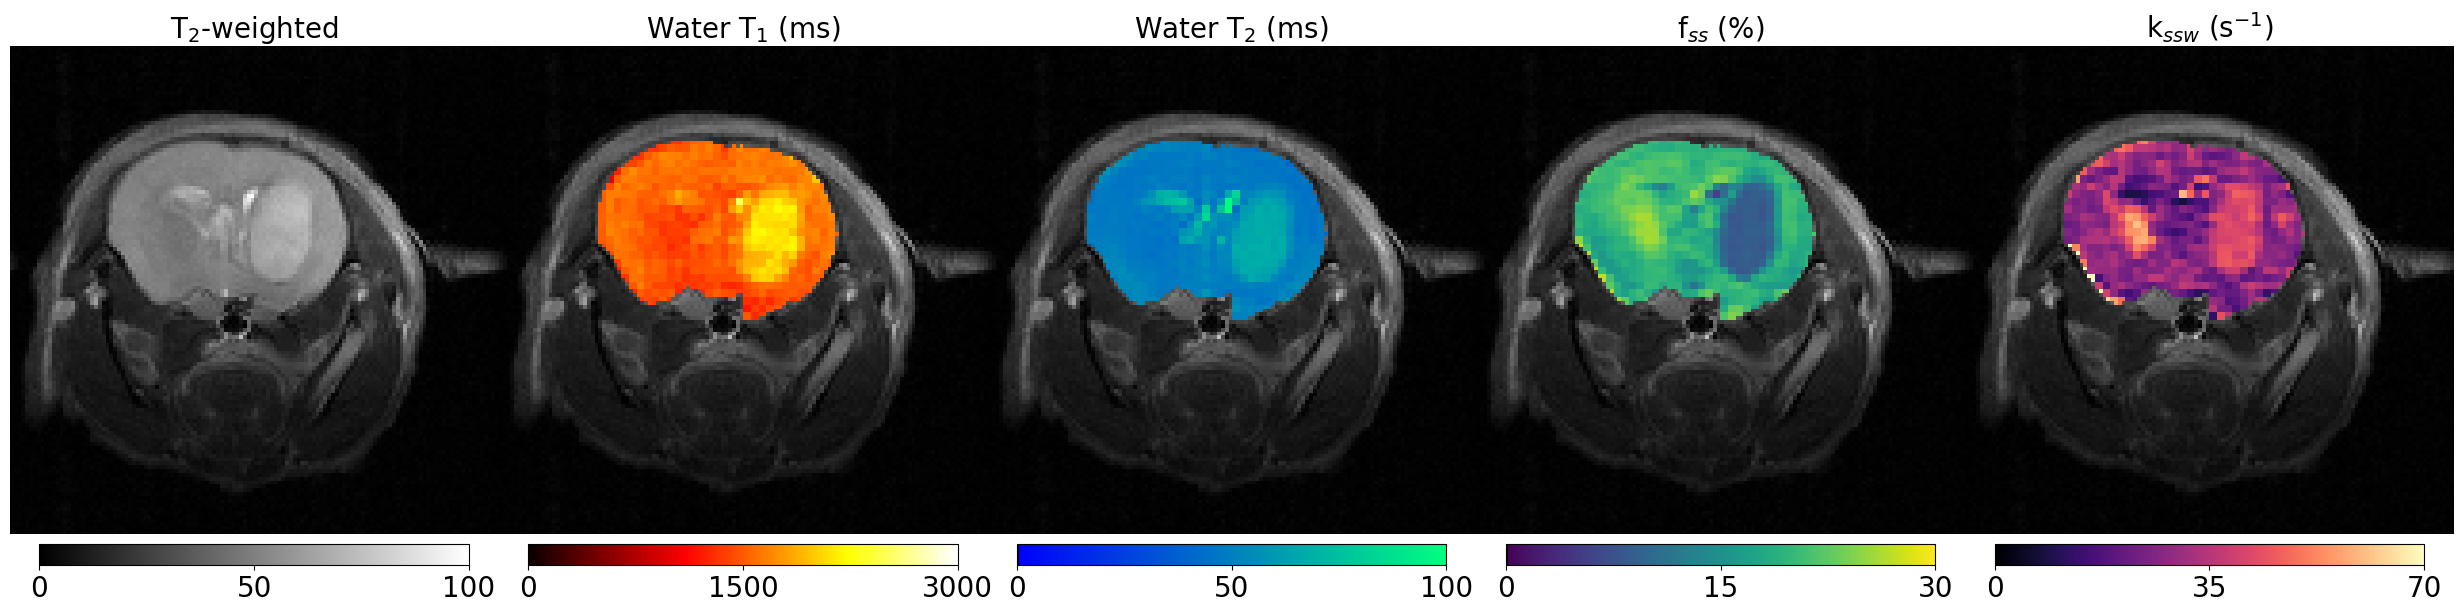

In [22]:
# mask = np.ones((c_acq_data, w_acq_data))
quant_maps = {}

# Reshaping back to the image dimension
quant_maps['fs'] = prediction.cpu().detach().numpy()[:, 0]
quant_maps['fs'] = quant_maps['fs'].T
quant_maps['fs'] = np.reshape(quant_maps['fs'], (c_acq_data, w_acq_data), order='F')

quant_maps['ksw'] = prediction.cpu().detach().numpy()[:, 1]
quant_maps['ksw'] = quant_maps['ksw'].T
quant_maps['ksw'] = np.reshape(quant_maps['ksw'], (c_acq_data, w_acq_data), order='F')

quant_maps['t2wh'] = highres_t2

quant_maps['t1w'] = acquired_map_t1w_orig * 1000
quant_maps['t2w'] = acquired_map_t2w_orig * 1000

# Saving output maps
sio.savemat(os.path.join(output_f, 'nn_reco_maps_m.mat'), quant_maps)


fig_fn = 'deep_reco_m.eps' # quantitative maps output filename
fig_fn = os.path.join(output_f, fig_fn)

fig, axes = plt.subplots(1, 5, figsize=(25, 10))

color_maps = ['gray', 'hot', b_winter, b_viridis, 'magma']
data_keys = ['t2wh', 't1w', 't2w', 'fs', 'ksw']
titles = ['T$_{{2}}$-weighted', 'Water T$_{{1}}$ (ms)','Water T$_{{2}}$ (ms)','f$_{{ss}}$ (%)', 'k$_{{ssw}}$ (s$^{-1}$)']
clim_list = [(0, 100), (0, 3000), (0, 100),(0, 30), (0, 70)]
tick_list = [ np.arange(0, 140, 50),np.arange(0, 3300, 1500), np.arange(0, 140, 50),
            np.arange(0, 60, 15), np.arange(0, 120, 35)]

unified_font_size = 20


for ax, color_map, key, title, clim, ticks in zip(axes.flat, color_maps, data_keys, titles, clim_list, tick_list):
    vals = quant_maps[key]

    if key == 'fs':
        vals = vals * 100

    mask_lr = cv2.resize(mask, (vals.shape[1], vals.shape[0]), interpolation=cv2.INTER_NEAREST)
    plot = ax.imshow(vals * mask_lr, cmap=color_map)
    plot.set_clim(*clim)
    ax.clear()
    ax.set_title(title, fontsize=unified_font_size)
    cb = plt.colorbar(plot, ax=ax, ticks=ticks, orientation='horizontal', fraction=0.023, pad=0.01)
    cb.ax.tick_params(labelsize=unified_font_size)
    ax.set_axis_off()
    if key != 't2wh':
        img = image_overlay(highres_t2, vals, mask, plt.cm.gray, color_map, clim, None, alphabg=1, alphafg=1)
        ax.imshow(img)
    else:
        ax.imshow(vals, cmap=color_map)

plt.tight_layout()
plt.subplots_adjust(wspace=0.001, hspace=0.0001)  # Remove spacing between subplots

plt.savefig(fig_fn, format='eps')